In [ ]:
!pip install "gluonts[mxnet,pro]"
!pip install "gluonts[torch,pro]"
!pip install yfinance


In [ ]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (30, 10)})

import sys
import os

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
btc_usd_h = pd.read_csv("data/Bitstamp_BTCUSD_1h.csv")
btc_usd_h = btc_usd_h.iloc[::-1]
btc_usd_h = btc_usd_h[["date", "close"]]
btc_usd_h.set_index("date", inplace=True)
btc_usd_h.head()
btc_usd_h.shape

,close
date,
2018-05-15 06:00:00,8740.99
2018-05-15 07:00:00,8739.00
2018-05-15 08:00:00,8728.49
2018-05-15 09:00:00,8708.32
2018-05-15 10:00:00,8795.90


(38467, 1)

(15385, 1)

<AxesSubplot:xlabel='date'>

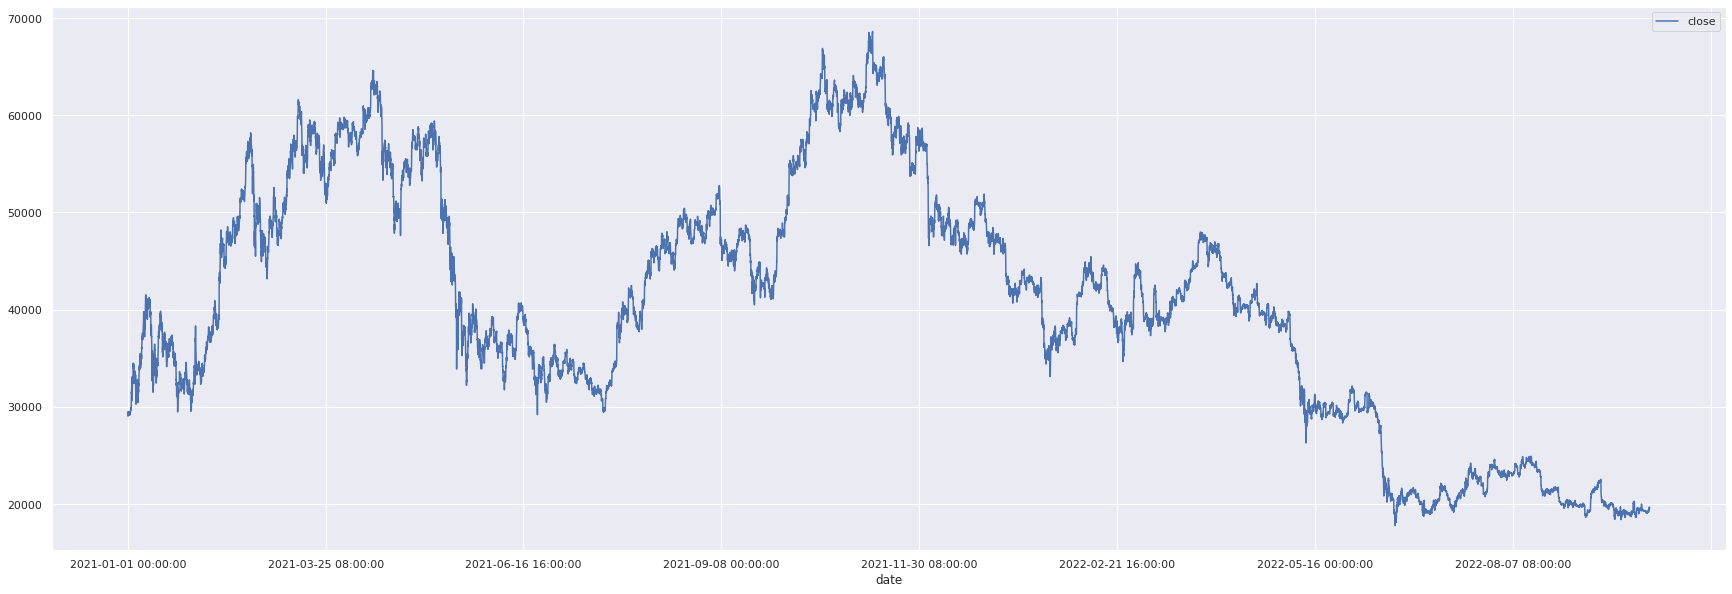

In [ ]:
# let's keep only the latests values which represents the actual behavior
btc_usd_h = btc_usd_h[btc_usd_h.index > "2021-01-01"]
btc_usd_h.shape
btc_usd_h.plot()

### ARIMA

(from <https://www.youtube.com/watch?v=gqryqIlvEoM&t=197s&ab_channel=DecisionForest>)

An Arima model is characterizer by 3 terms (p, d, q):
* p is the order of the AR term
* d is the number of differencing required to make the time series stationary
* q is the order of the MA term

AS we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.

#### Stationarity - d term

Substract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times.

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model.



##### Stationarity test (ADF Test)

We'll use the Augmented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary? So, if the p-valuee of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(btc_usd_h.close)
print(f'ADF statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF statistic: -1.2531247478990908
p-value: 0.6503358770527379


##### Autocorrelation Function (ACF)

ACF will help to find how many differentiations are needed (find the 'd' parameter)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

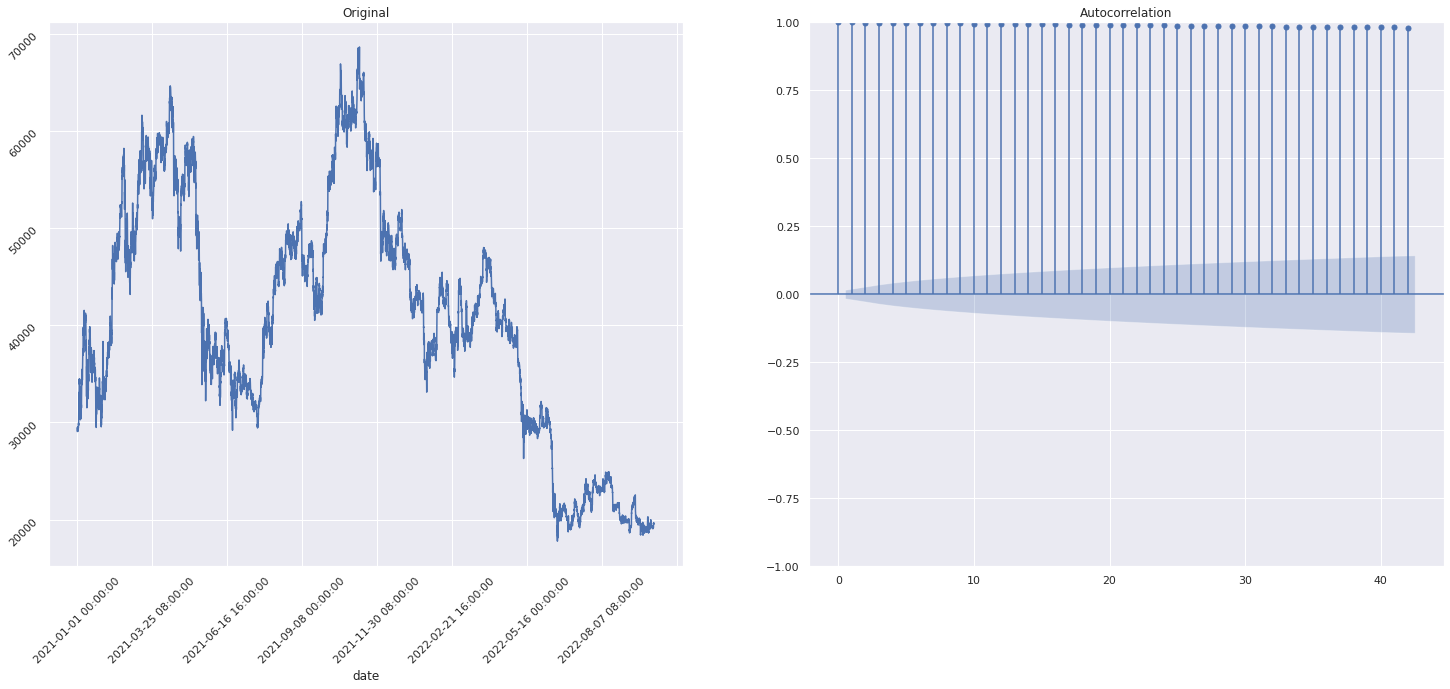

In [ ]:

def draw_acf(f, legend="Original"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))    
    f.plot(ax=ax1)
    ax1.set_title(legend)
    ax1.tick_params(labelrotation=45)
    plot_acf(f, ax=ax2);


draw_acf(btc_usd_h.close)

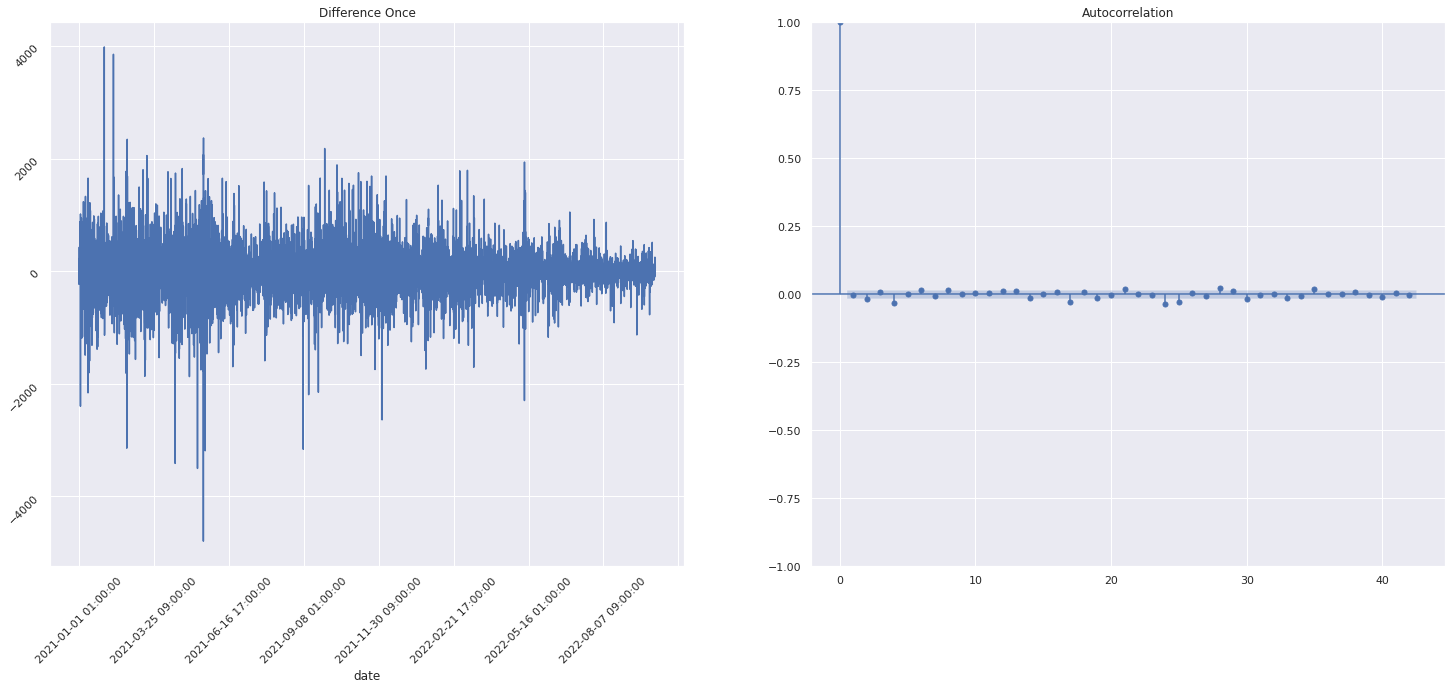

In [ ]:
diff = btc_usd_h.close.diff().dropna()
draw_acf(diff, "Difference Once")


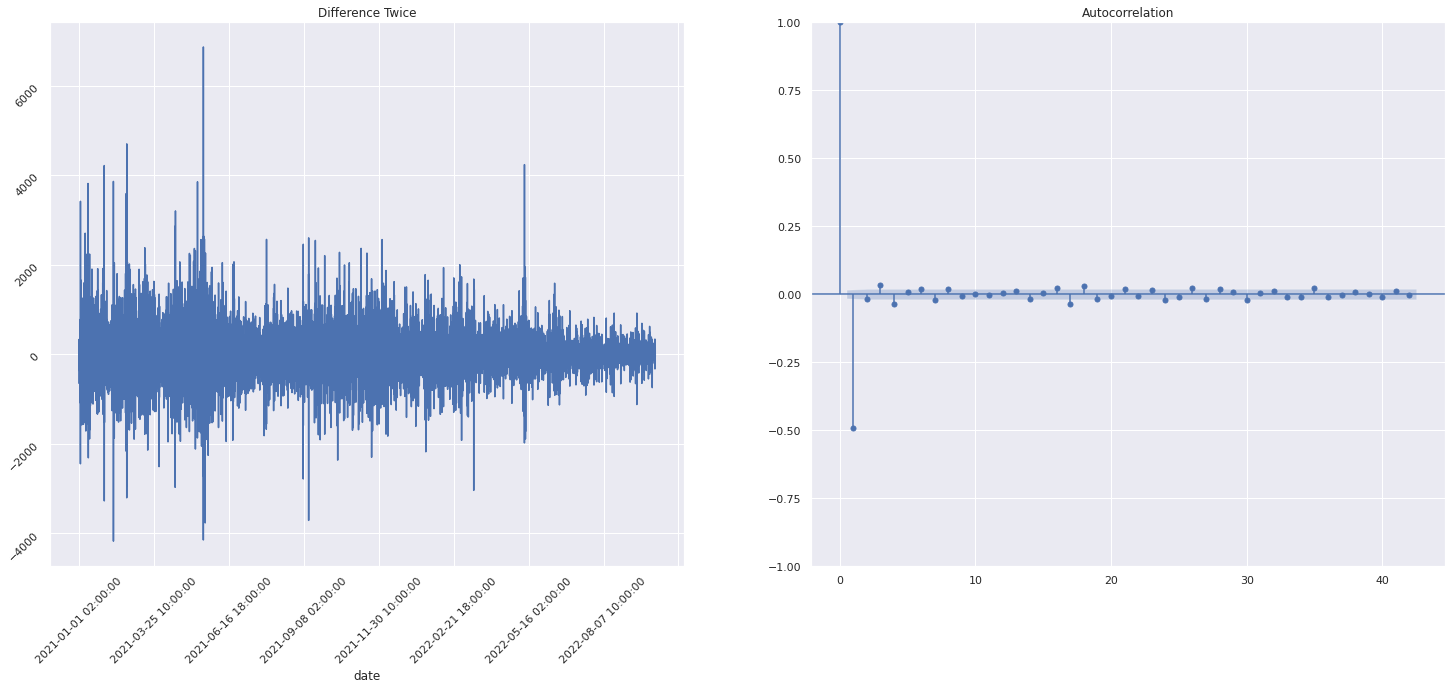

In [ ]:

diff = btc_usd_h.close.diff().diff().dropna()
draw_acf(diff, "Difference Twice")


On the later, the autocorellation goes deep in the negative, so that might mean that we've been over differencing.

So we can choose the order of differencing of just 1.

We can use pmdarim package to get the number of differencing

In [ ]:
from pmdarima.arima.utils import ndiffs


In [ ]:
ndiffs(btc_usd_h.close, test="adf")

1

#### Auto Regressive - p term

P is the order od the Auto Regressive (AR) term. It refers to the number of lags to be used as predistors.

We can find out the requires numver of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

Tha partial autocorrelation represents the correlation between the series and its lags.

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf


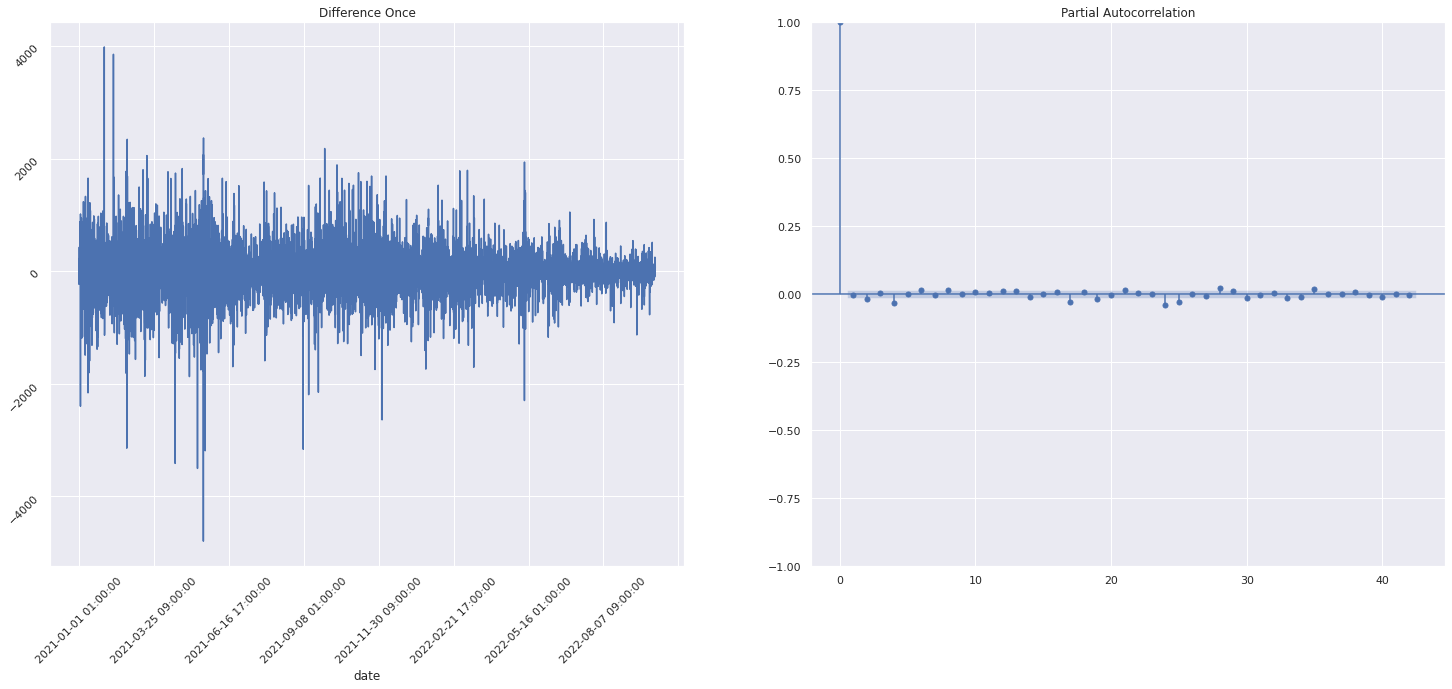

In [ ]:
f = btc_usd_h.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))    
f.plot(ax=ax1)
ax1.set_title("Difference Once")
ax1.tick_params(labelrotation=45)
plot_pacf(f, ax=ax2);

We can observe that PACF lag value of 4 is significant as is above (below ?) the significance line.

#### Moving Average - q term

q is the order of the Moving Average (MA) term. it refers to the number of lagged forecat errors that should go into the ARIMA Model.

We can look at the ACF plot for the cumber of MA terms.

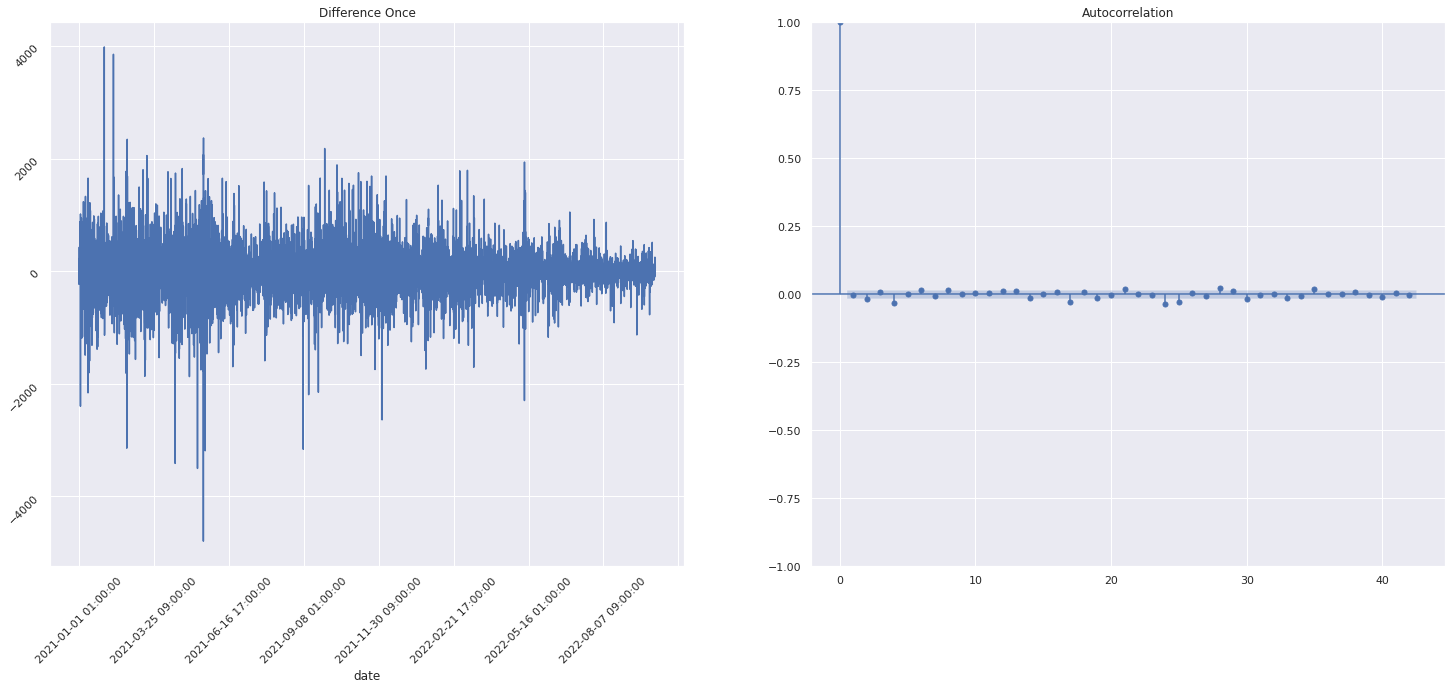

In [ ]:
diff = btc_usd_h.close.diff().dropna()
draw_acf(diff, "Difference Once")

Following results from previous ACL grapsh, we can take a value of 4.

#### Fitting ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(btc_usd_h.close, order=(4, 1, 4))
result = model.fit()
print(result.summary())

/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                15385
Model:                 ARIMA(4, 1, 4)   Log Likelihood             -111771.681
Date:                Thu, 06 Oct 2022   AIC                         223561.361
Time:                        15:53:47   BIC                         223630.131
Sample:                    01-01-2021   HQIC                        223584.150
                         - 10-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0703      0.163     -0.431      0.667      -0.390       0.249
ar.L2         -0.0351      0.159     -0.221      0.825      -0.346       0.276
ar.L3          0.0635      0.138      0.461      0.6

<AxesSubplot:xlabel='date'>

array([<AxesSubplot:title={'center':'0'}>], dtype=object)

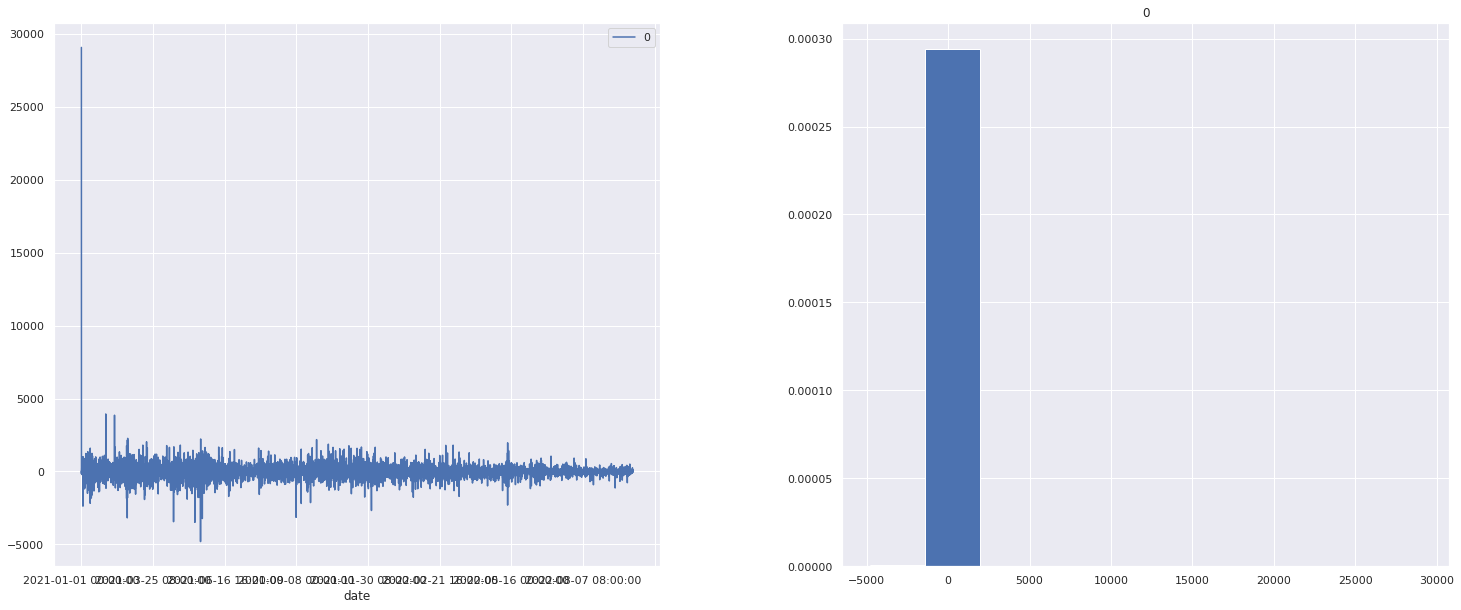

In [ ]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))    
residuals.plot(ax=ax1)

residuals.hist(ax=ax2, density=True)

In [ ]:
# Actual vs fitted

result.plot_predict(
    start= 1,
    end=60,
    dynamic=False
)

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'